## Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition. For many incumbent operators, retaining high profitable customers is the number one business goal.

Approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.


## Objective

To analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

Churn here means: Where there is no usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

In this case study, we need to define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

### Importing Libraries

In [6]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#To ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Data Understanding

In [7]:
df = pd.read_csv(r"telecom_churn_data.csv")
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [8]:
df.shape

(99999, 226)

In [9]:
df.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [10]:
#Renaming columns containing month names with numbers to make the data uniform
# aug_vbc_3g, jul_vbc_3g,jun_vbc_3g, sep_vbc_3g 
# 'vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6', 'vbc_3g_9'
df.rename(columns = {'aug_vbc_3g' : 'vbc_3g_8', 'jul_vbc_3g' :'vbc_3g_7',
                               'jun_vbc_3g' : 'vbc_3g_6', 'sep_vbc_3g' : 'vbc_3g_9'}, inplace =True)

### High value customers

We need to predict churn only for the high-value customers. And we define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In order to do this, we will take average of the total_rech_amt_6 &  total_rech_amt_7 and then identify the rows where the average value is above 70%

In [11]:
#checking for nulls in total_rech_amt_6 & total_rech_amt_7
df[['total_rech_amt_6','total_rech_amt_7']].isnull().sum()/len(df.index)*100

total_rech_amt_6    0.0
total_rech_amt_7    0.0
dtype: float64

No null values in these columns and hence we can safely take their average.

In [12]:
#new dataframe with only high value customers
high_value_cust_data = df[(df.total_rech_amt_6 + df.total_rech_amt_7)/2 > ((df.total_rech_amt_6 + df.total_rech_amt_7)/2).quantile(0.7)]
high_value_cust_data.shape

(29979, 226)

As expected, there are about 29.9k rows

### Create a new Churn column

We will define the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes we will  use to tag churners are:

- total_ic_mou_9

- total_og_mou_9

- vol_2g_mb_9

- vol_3g_mb_9

In [13]:
#adding churn column with initial value as 0
high_value_cust_data['Churn'] = 0

In [14]:
#imputing Churn as 1 based on the usage of four columns as described above
high_value_cust_data.loc[(high_value_cust_data.total_ic_mou_9 == 0) & (high_value_cust_data.total_og_mou_9==0) & 
                         (high_value_cust_data.vol_2g_mb_9 == 0) & (high_value_cust_data.vol_3g_mb_9 == 0), 'Churn'] = 1

Now that we have defined the churned column, we need to remove (as also mentioned in the problem statement) all the columns corresponding to 'churn' phase i.e. all attributes having ‘ _9’, etc. in their names.

In [15]:
high_value_cust_data.drop(high_value_cust_data.columns[high_value_cust_data.columns.str.endswith('_9')]
                          , axis = 1, inplace = True)

In [16]:
high_value_cust_data.shape

(29979, 172)

In [17]:
#looking at the churn rate
round((sum(high_value_cust_data['Churn'])/len(high_value_cust_data['Churn'].index)*100),2)

8.64

We can observe that there is a class imbalance here as the churn rate is quite low

### Data Cleaning

In [18]:
high_value_cust_data.columns[high_value_cust_data.dtypes == object]

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')

In [19]:
#checking for nulls in each column
nulls = round((high_value_cust_data.isnull().sum()/len(high_value_cust_data.index))*100,2).to_frame().reset_index()
nulls.rename(columns= {0: 'pcnt_missing','index':'column'},inplace=True)
nulls[nulls.pcnt_missing > 0]

,column,pcnt_missing
2,loc_og_t2o_mou,0.38
3,std_og_t2o_mou,0.38
4,loc_ic_t2o_mou,0.38
6,last_date_of_month_7,0.10
7,last_date_of_month_8,0.52
11,onnet_mou_6,1.05
12,onnet_mou_7,1.01
13,onnet_mou_8,3.13
14,offnet_mou_6,1.05
15,offnet_mou_7,1.01


For columns with very less null values such as between 1% to 10%, we can impute the missing values as 0. 

In [20]:
nulls_1_10 = nulls[(nulls.pcnt_missing >= 0.01) & (nulls.pcnt_missing <= 10)]
high_value_cust_data [nulls_1_10.column] = high_value_cust_data[nulls_1_10.column].fillna(0)

In [21]:
#checking for missing values between 10% and 20%
nulls[(nulls.pcnt_missing >= 10) & (nulls.pcnt_missing <= 20)]


,column,pcnt_missing


We can see there are no columns having missing values between 10% and 20%

In [22]:
#chekcing for missing values greater than 20%
nulls[(nulls.pcnt_missing >= 20)]

,column,pcnt_missing
119,date_of_last_rech_data_6,62.02
120,date_of_last_rech_data_7,61.13
121,date_of_last_rech_data_8,60.84
122,total_rech_data_6,62.02
123,total_rech_data_7,61.13
124,total_rech_data_8,60.84
125,max_rech_data_6,62.02
126,max_rech_data_7,61.13
127,max_rech_data_8,60.84
128,count_rech_2g_6,62.02


#### Looking at the pre-existing data, the following inferences were made
- count_rech_2g = monthly_2g_* + sachet_2g_*
- count_rech_3g = monthly_3g_* + sachet_3g_*
- total_rech_data = count_rech_2g_* + count_rech_3g_*

*represents the month 6,7,8,9 (june,july,aug,sep)

In [23]:
for i in [6,7,8]:
    high_value_cust_data['count_rech_2g_'+str(i)] = high_value_cust_data['monthly_2g_'+str(i)] +  high_value_cust_data['sachet_2g_'+str(i)]
    high_value_cust_data['count_rech_3g_'+str(i)] = high_value_cust_data['monthly_3g_'+str(i)] +  high_value_cust_data['sachet_3g_'+str(i)]

In [24]:
for i in [6,7,8]:
    high_value_cust_data['total_rech_data_'+str(i)] = high_value_cust_data['count_rech_2g_'+str(i)] +  high_value_cust_data['count_rech_3g_'+str(i)]

In [25]:
#checking for nulls in each column again
nulls = round((high_value_cust_data.isnull().sum()/len(high_value_cust_data.index))*100,2).to_frame().reset_index()
nulls.rename(columns= {0: 'pcnt_missing','index':'column'},inplace=True)
nulls[nulls.pcnt_missing > 0]

,column,pcnt_missing
119,date_of_last_rech_data_6,62.02
120,date_of_last_rech_data_7,61.13
121,date_of_last_rech_data_8,60.84
125,max_rech_data_6,62.02
126,max_rech_data_7,61.13
127,max_rech_data_8,60.84
134,av_rech_amt_data_6,62.02
135,av_rech_amt_data_7,61.13
136,av_rech_amt_data_8,60.84
143,arpu_3g_6,62.02


#### Under the assumption that the customer had not applied voluntarily for any data packs (2g or 3g), the inference extracted was 
- if count_rech_2g_* & count_rech_3g_* == 0 then the max_rech_data_* & av_rech_amt_data_* is also 0

In [26]:
for i in [6,7,8]:
    high_value_cust_data['max_rech_data_'+str(i)]  = high_value_cust_data.apply(lambda x: 0 if x['count_rech_2g_'+str(i)] + x['count_rech_3g_'+str(i)] == 0 else x['max_rech_data_'+str(i)], axis = 1 )
    high_value_cust_data['av_rech_amt_data_'+str(i)] = high_value_cust_data.apply(lambda x: 0 if x['count_rech_2g_'+str(i)] + x['count_rech_3g_'+str(i)] == 0 else x['av_rech_amt_data_'+str(i)], axis = 1 )

In [27]:
#checking for nulls in each column again
nulls = round((high_value_cust_data.isnull().sum()/len(high_value_cust_data.index))*100,2).to_frame().reset_index()
nulls.rename(columns= {0: 'pcnt_missing','index':'column'},inplace=True)
nulls[nulls.pcnt_missing > 0]

,column,pcnt_missing
119,date_of_last_rech_data_6,62.02
120,date_of_last_rech_data_7,61.13
121,date_of_last_rech_data_8,60.84
143,arpu_3g_6,62.02
144,arpu_3g_7,61.13
145,arpu_3g_8,60.84
146,arpu_2g_6,62.02
147,arpu_2g_7,61.13
148,arpu_2g_8,60.84
149,night_pck_user_6,62.02


#### Checking for correlations between columns that have missing values and also with CHurn column

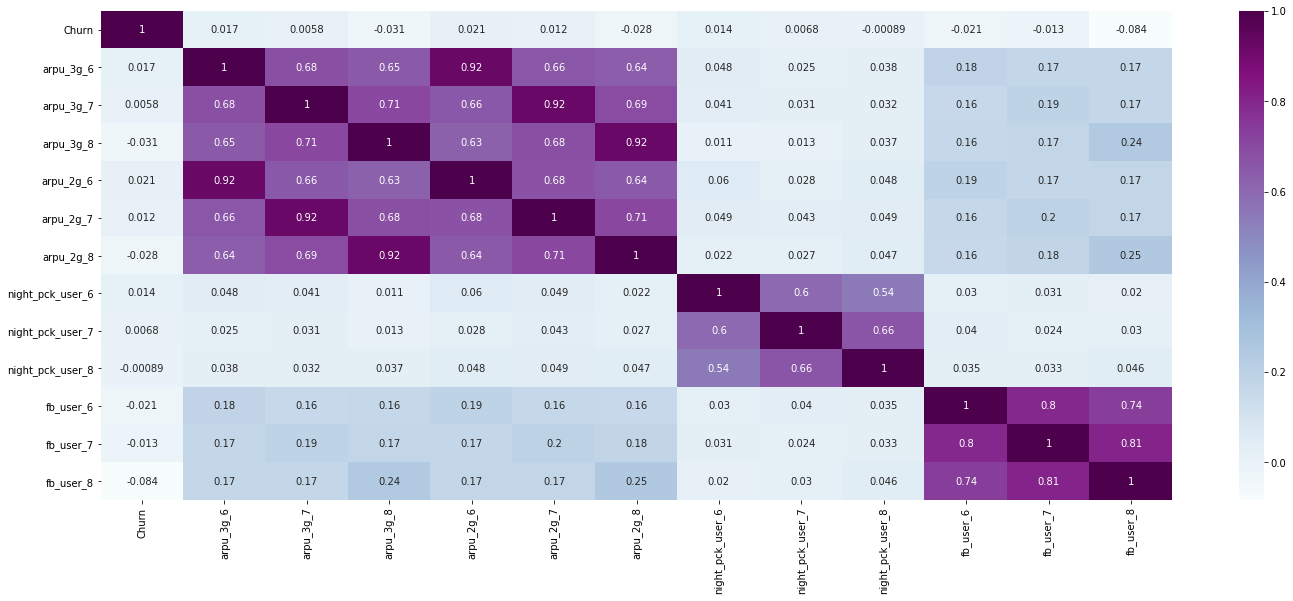

In [28]:
# Checking correlations
cor = high_value_cust_data[['Churn','arpu_3g_6','arpu_3g_7', 'arpu_3g_8','arpu_2g_6','arpu_2g_7',
                           'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8',
                           'fb_user_6', 'fb_user_7', 'fb_user_8']].corr()
plt.figure(figsize=(24,9))
sns.heatmap(cor,cmap="BuPu", annot=True)
plt.show()


##### From above, we can see  that night_pck_user_6,7,8 , fb_user_6,7,8 and arpu columns are not  correlated with Churn, hence are almost ineffective and can be dropped.

In [29]:
high_value_cust_data.drop(['night_pck_user_6','night_pck_user_7','night_pck_user_8',
                           'fb_user_6','fb_user_7','fb_user_8', 'arpu_2g_6','arpu_2g_7','arpu_2g_8','arpu_3g_6',
                           'arpu_3g_7','arpu_3g_8'],axis=1,inplace=True)

In [30]:
#checking for nulls in each column again
nulls = round((high_value_cust_data.isnull().sum()/len(high_value_cust_data.index))*100,2).to_frame().reset_index()
nulls.rename(columns= {0: 'pcnt_missing','index':'column'},inplace=True)
nulls[nulls.pcnt_missing > 0]

,column,pcnt_missing
119,date_of_last_rech_data_6,62.02
120,date_of_last_rech_data_7,61.13
121,date_of_last_rech_data_8,60.84


#### Feature engineering with Date columns
We can create new columns to find the difference in days for the last recharge and last data recharge

In [31]:
high_value_cust_data['diff_rch_days_6'] = pd.DatetimeIndex(high_value_cust_data['last_date_of_month_6']).day - pd.DatetimeIndex(high_value_cust_data['date_of_last_rech_6']).day
high_value_cust_data['diff_rch_days_7'] = pd.DatetimeIndex(high_value_cust_data['last_date_of_month_7']).day - pd.DatetimeIndex(high_value_cust_data['date_of_last_rech_7']).day
high_value_cust_data['diff_rch_days_8'] = pd.DatetimeIndex(high_value_cust_data['last_date_of_month_8']).day - pd.DatetimeIndex(high_value_cust_data['date_of_last_rech_8']).day

high_value_cust_data['diff_rch_data_days_6'] = pd.DatetimeIndex(high_value_cust_data['last_date_of_month_6']).day - pd.DatetimeIndex(high_value_cust_data['date_of_last_rech_data_6']).day
high_value_cust_data['diff_rch_data_days_7'] = pd.DatetimeIndex(high_value_cust_data['last_date_of_month_7']).day - pd.DatetimeIndex(high_value_cust_data['date_of_last_rech_data_7']).day
high_value_cust_data['diff_rch_data_days_8'] = pd.DatetimeIndex(high_value_cust_data['last_date_of_month_8']).day - pd.DatetimeIndex(high_value_cust_data['date_of_last_rech_data_8']).day

Now we can drop the columns from which above features derived

In [32]:
high_value_cust_data.drop(["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8", "date_of_last_rech_data_6",
                       "date_of_last_rech_data_7","date_of_last_rech_data_8", "last_date_of_month_6", "last_date_of_month_7",
                       "last_date_of_month_8"], axis = 1, inplace=True)

In [33]:
#checking for nulls in each column again
nulls = round((high_value_cust_data.isnull().sum()/len(high_value_cust_data.index))*100,2).to_frame().reset_index()
nulls.rename(columns= {0: 'pcnt_missing','index':'column'},inplace=True)
nulls[nulls.pcnt_missing > 0]

,column,pcnt_missing
154,diff_rch_data_days_6,62.02
155,diff_rch_data_days_7,61.13
156,diff_rch_data_days_8,60.84


In [34]:
high_value_cust_data[['diff_rch_data_days_6','diff_rch_data_days_7','diff_rch_data_days_7']].describe()

,diff_rch_data_days_6,diff_rch_data_days_7,diff_rch_data_days_7
count,11387.000000,11652.000000,11652.000000
mean,10.496531,10.606849,10.606849
std,8.409710,8.588275,8.588275
min,0.000000,0.000000,0.000000
25%,3.000000,3.000000,3.000000
50%,9.000000,9.000000,9.000000
75%,17.000000,17.000000,17.000000
max,29.000000,30.000000,30.000000


In [35]:
#imputing null difference days with median
high_value_cust_data['diff_rch_data_days_6'] = high_value_cust_data['diff_rch_data_days_6'].fillna(high_value_cust_data['diff_rch_data_days_6'].median())
high_value_cust_data['diff_rch_data_days_7'] = high_value_cust_data['diff_rch_data_days_7'].fillna(high_value_cust_data['diff_rch_data_days_7'].median())
high_value_cust_data['diff_rch_data_days_8'] = high_value_cust_data['diff_rch_data_days_8'].fillna(high_value_cust_data['diff_rch_data_days_8'].median())


In [36]:
#checking for nulls in each column again
nulls = round((high_value_cust_data.isnull().sum()/len(high_value_cust_data.index))*100,2).to_frame().reset_index()
nulls.rename(columns= {0: 'pcnt_missing','index':'column'},inplace=True)
nulls[nulls.pcnt_missing > 0]

,column,pcnt_missing


As seen above, all missing data has now been handled

#### Checking for columns which have no variance

In [37]:
no_variance_columns = list(high_value_cust_data.columns[high_value_cust_data.nunique()  == 1])
high_value_cust_data[no_variance_columns].columns

Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'],
      dtype='object')

From above, we can see that all these columns have only one value and hence add no value to the overall data as its variance is 0. It is safe to drop these columns

In [38]:
#dropping columns with no variance
high_value_cust_data.drop(no_variance_columns, axis = 1, inplace=True)

In [39]:
#we can also drop mobile number column as that is not required for modelling
high_value_cust_data.drop('mobile_number', axis = 1, inplace=True)

In [40]:
high_value_cust_data.shape

(29979, 146)

In [41]:
high_value_cust_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29979 entries, 7 to 99997
Columns: 146 entries, arpu_6 to diff_rch_data_days_8
dtypes: float64(108), int64(38)
memory usage: 33.6 MB


### Drawing insights from the cleaned dataset
##### Exploratory Data Analysis
Lets analyze as to what influences a customer to churn

In [41]:
#getting churned into a separate df
churned_customers = high_value_cust_data[high_value_cust_data.Churn == 1]

In [42]:
#check arpu
cols = churned_customers.columns[churned_customers.columns.str.contains('arpu')]
cols

Index(['arpu_6', 'arpu_7', 'arpu_8'], dtype='object')

The arpu usage across June, july and August

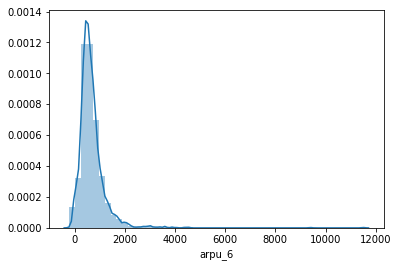

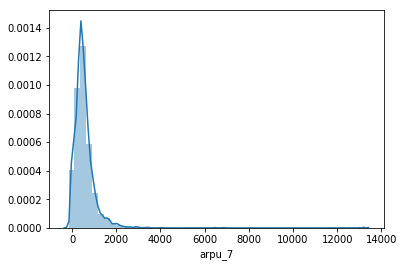

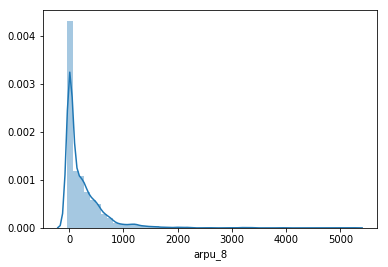

In [43]:
for col in cols:
    sns.distplot(churned_customers[col])
    plt.show()

We see that the arpu decreases as the months progress

In [44]:
#checking incoming, outgoings calls and data
total_ic_cols = high_value_cust_data.columns[high_value_cust_data.columns.str.contains('total_ic')]
total_og_cols = high_value_cust_data.columns[high_value_cust_data.columns.str.contains('total_og')]
total_rech_num_cols =  high_value_cust_data.columns[high_value_cust_data.columns.str.contains('total_rech_num')]
total_rech_amt_cols =  high_value_cust_data.columns[high_value_cust_data.columns.str.contains('total_rech_amt')]
total_rech_data_cols = high_value_cust_data.columns[high_value_cust_data.columns.str.contains('total_rech_data')]

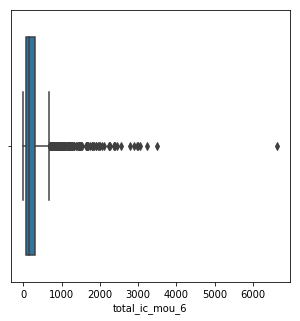

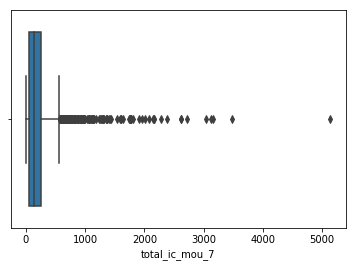

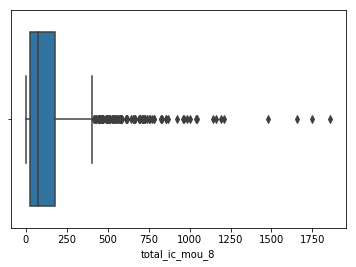

In [45]:
plt.figure(figsize = (5,5))
for col in total_ic_cols:
    plt.yticks(range(0,int(churned_customers[col].max()),500))
    sns.boxplot(churned_customers[col][churned_customers[col] != 0 ])
    plt.show()

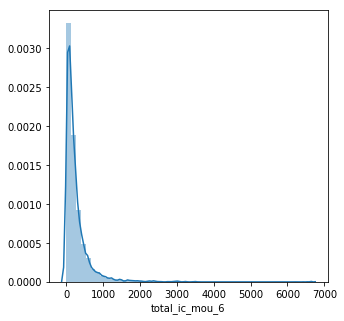

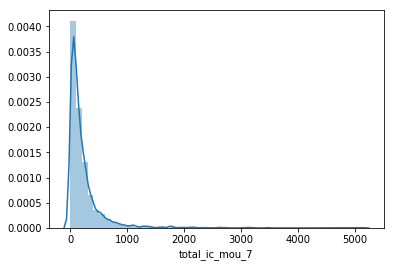

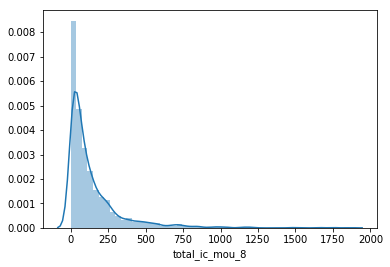

In [46]:
plt.figure(figsize = (5,5))
for col in total_ic_cols:
    #plt.yticks(range(0,int(churned_customers[col].max()),500))
    sns.distplot(churned_customers[col][churned_customers[col] != 0 ])
    plt.show()

We notice that the total incoming consumption dropped. The customer's incoming calls reduced or the customer must have been spending less time on incoming calls

The churned customers tend to pay more for 3g data as the months progressed. The Volume BAsed Consumptin shows the amount spent by a customer on 3g data wihtout the use of any packs. We can infer that the expenditure of the customer on 3g data increased.

In [47]:
#checking volume of consumption of data
req_cols = high_value_cust_data.columns[high_value_cust_data.columns.str.contains('vol')]

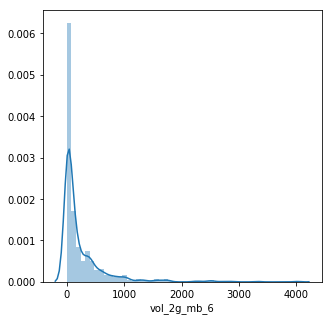

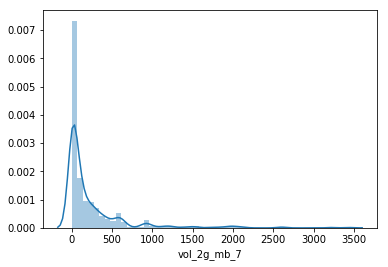

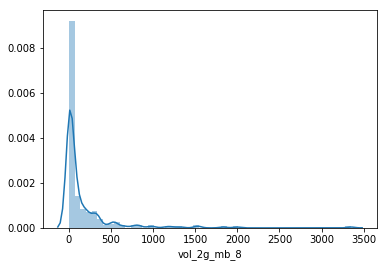

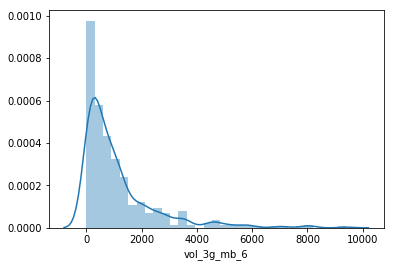

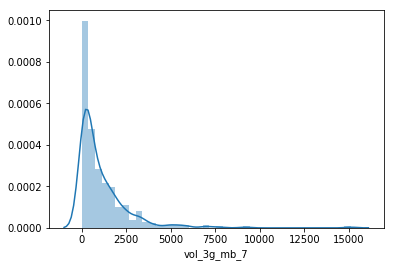

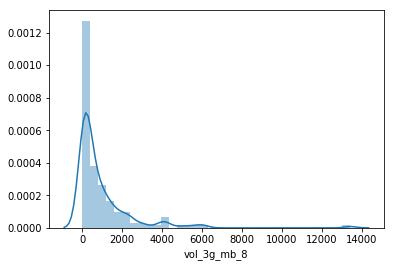

In [48]:
plt.figure(figsize = (5,5))
for col in req_cols:
    #plt.title(month_names[c])
    #plt.yticks(range(0,int(churned_customers[col].max()),500))
    sns.distplot(churned_customers[col][churned_customers[col] != 0 ])
    plt.show()

The volume of consumption of data via monthly recharges and satchets reduces as the months go by 

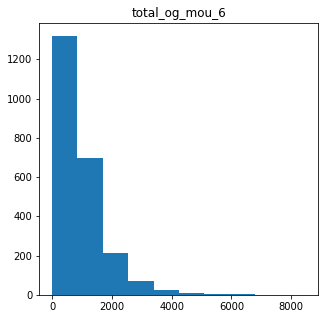

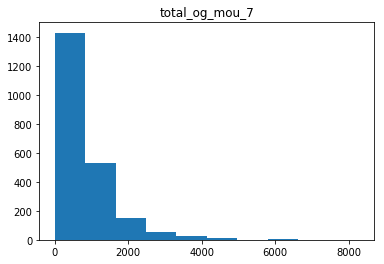

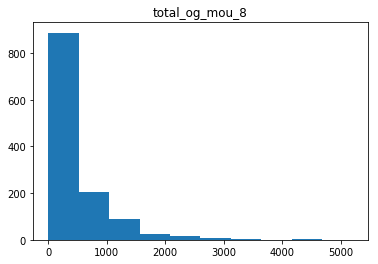

In [49]:
#total outgoing
plt.figure(figsize = (5,5))
for col in total_og_cols:
    #plt.yticks(range(0,int(churned_customers[col].max()),500))
    plt.title(col)
    plt.hist(churned_customers[col][churned_customers[col] != 0 ])
    plt.show()

During the good phase the usage of out going minutes increased. But, by August the usage decreased.

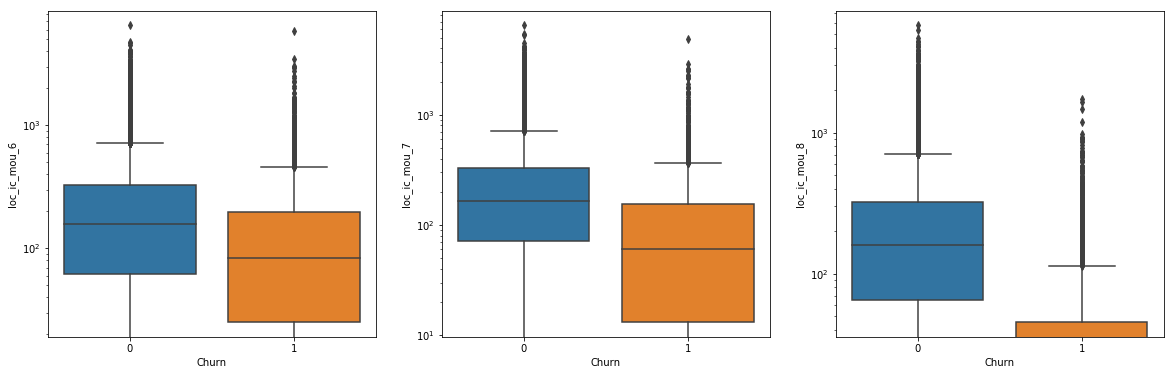

In [50]:
#local incoming in 8th month and churn

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.yscale('log')
sns.boxplot(x = high_value_cust_data.Churn, y = high_value_cust_data.loc_ic_mou_6)
plt.subplot(1,3,2)
plt.yscale('log')
sns.boxplot(x = high_value_cust_data.Churn, y = high_value_cust_data.loc_ic_mou_7)
plt.subplot(1,3,3)
plt.yscale('log')
sns.boxplot(x = high_value_cust_data.Churn, y = high_value_cust_data.loc_ic_mou_8)

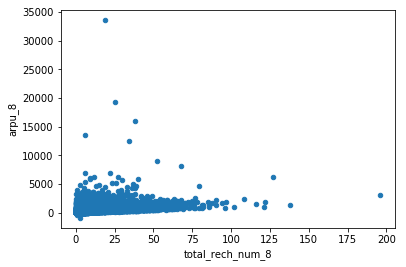

In [51]:
# Looking relation between total no.of recharge and average revenue/user in 8th month.
high_value_cust_data[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',
                                                              y='arpu_8')

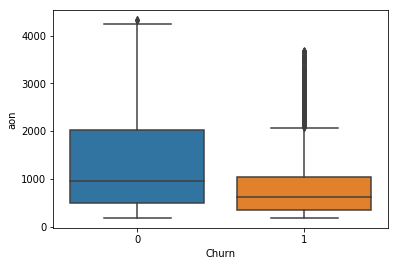

In [52]:
#checking age on network v churn

sns.boxplot(x = high_value_cust_data.Churn, y = high_value_cust_data.aon)

#### From all the above EDA, following inferences can be drawn:

- Behaviour in 8 Month is a very strong indicator of churn
- Customers with less than 1000 day or 3years of age on network are more likely to churn.
- People recharging with less amount are more likely to churn
-  Local Incoming and Outgoing Calls for 8th Month and Average Revenue in 8th Month are 
   strong indicators of Churn.


## Model Building

We'll take the following steps to build our models for this case study

- First we'll use PCA to reduce the dimesions of the dataset and also to remove any multicollinearity in the data
- Then we'll build a base model such as logistic regression using both PCA and RFE
- And then we'll  build a model from a tree family such as Random Forest or Gradient Boosting
- We'll also find out important features affecting churn and will also handle class imbalance in the dataset

####  Applying PCA on the dataset

In [53]:
#scaling the data for conducting PCA
df = high_value_cust_data.drop(['Churn'], axis = 1)
normalized_df=(df-df.mean())/df.std()

In [54]:
df_1 = high_value_cust_data[['Churn']]
high_value_cust_data_scaled = pd.concat([df_1, normalized_df],axis = 1)

In [55]:
# Putting feature variables to X
X = high_value_cust_data_scaled.drop(['Churn'],axis=1)

# Putting response variable to y
y = high_value_cust_data_scaled['Churn']

In [56]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [57]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [58]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [60]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[3],'Feature':colnames})

In [61]:
pcs_df.head(20)

,PC1,PC2,PC3,Feature
0,0.080772,0.139816,0.085656,arpu_6
1,0.087305,0.156255,0.089545,arpu_7
2,0.093167,0.156475,0.080993,arpu_8
3,-0.058062,0.103549,-0.031185,onnet_mou_6
4,-0.060657,0.114780,-0.033843,onnet_mou_7
5,-0.046306,0.117194,-0.034599,onnet_mou_8
6,-0.018778,0.146271,0.007352,offnet_mou_6
7,-0.021713,0.159339,0.007226,offnet_mou_7
8,-0.005445,0.159505,0.005948,offnet_mou_8
9,0.006006,0.008623,0.035424,roam_ic_mou_6


In [62]:
pca.explained_variance_ratio_

array([9.38993171e-02, 8.27446439e-02, 7.01455173e-02, 5.42502578e-02,
       4.16462239e-02, 3.70600061e-02, 3.04224892e-02, 2.67278181e-02,
       2.55311141e-02, 2.33387919e-02, 2.22913219e-02, 2.14200763e-02,
       2.09205346e-02, 1.98909325e-02, 1.83268887e-02, 1.73044019e-02,
       1.62233104e-02, 1.57438649e-02, 1.55323046e-02, 1.24766796e-02,
       1.19660779e-02, 1.16720422e-02, 1.08244101e-02, 1.03862098e-02,
       9.59862242e-03, 9.56619823e-03, 8.58115693e-03, 8.19598674e-03,
       8.01349874e-03, 7.68301517e-03, 7.44127670e-03, 7.18150133e-03,
       7.10049420e-03, 6.86278785e-03, 6.59541379e-03, 6.50206190e-03,
       6.38653117e-03, 6.19651192e-03, 5.98586065e-03, 5.84880967e-03,
       5.68999229e-03, 5.53580675e-03, 5.47865863e-03, 5.45737989e-03,
       5.30608239e-03, 5.06376049e-03, 4.89847520e-03, 4.81638598e-03,
       4.66553099e-03, 4.41023230e-03, 4.30585249e-03, 4.12054624e-03,
       4.07600451e-03, 3.95684735e-03, 3.87195365e-03, 3.65342886e-03,
      

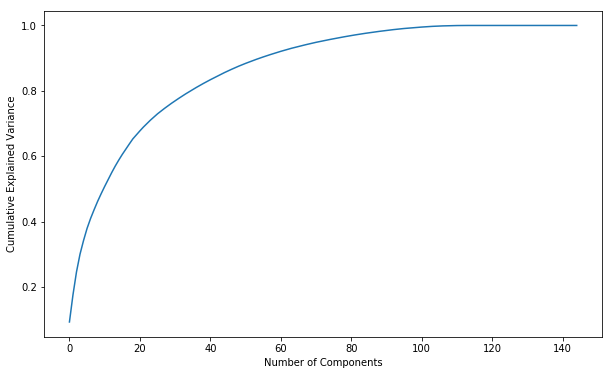

In [63]:
#plotting the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

From above, we can see 80 components looks to be a good choice to explain more than 90% of the variance in the dataset and hence we'll choose 80 PCs for our modelling

In [64]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=80)

In [65]:
#basis transformation
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(20985, 80)

In [66]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

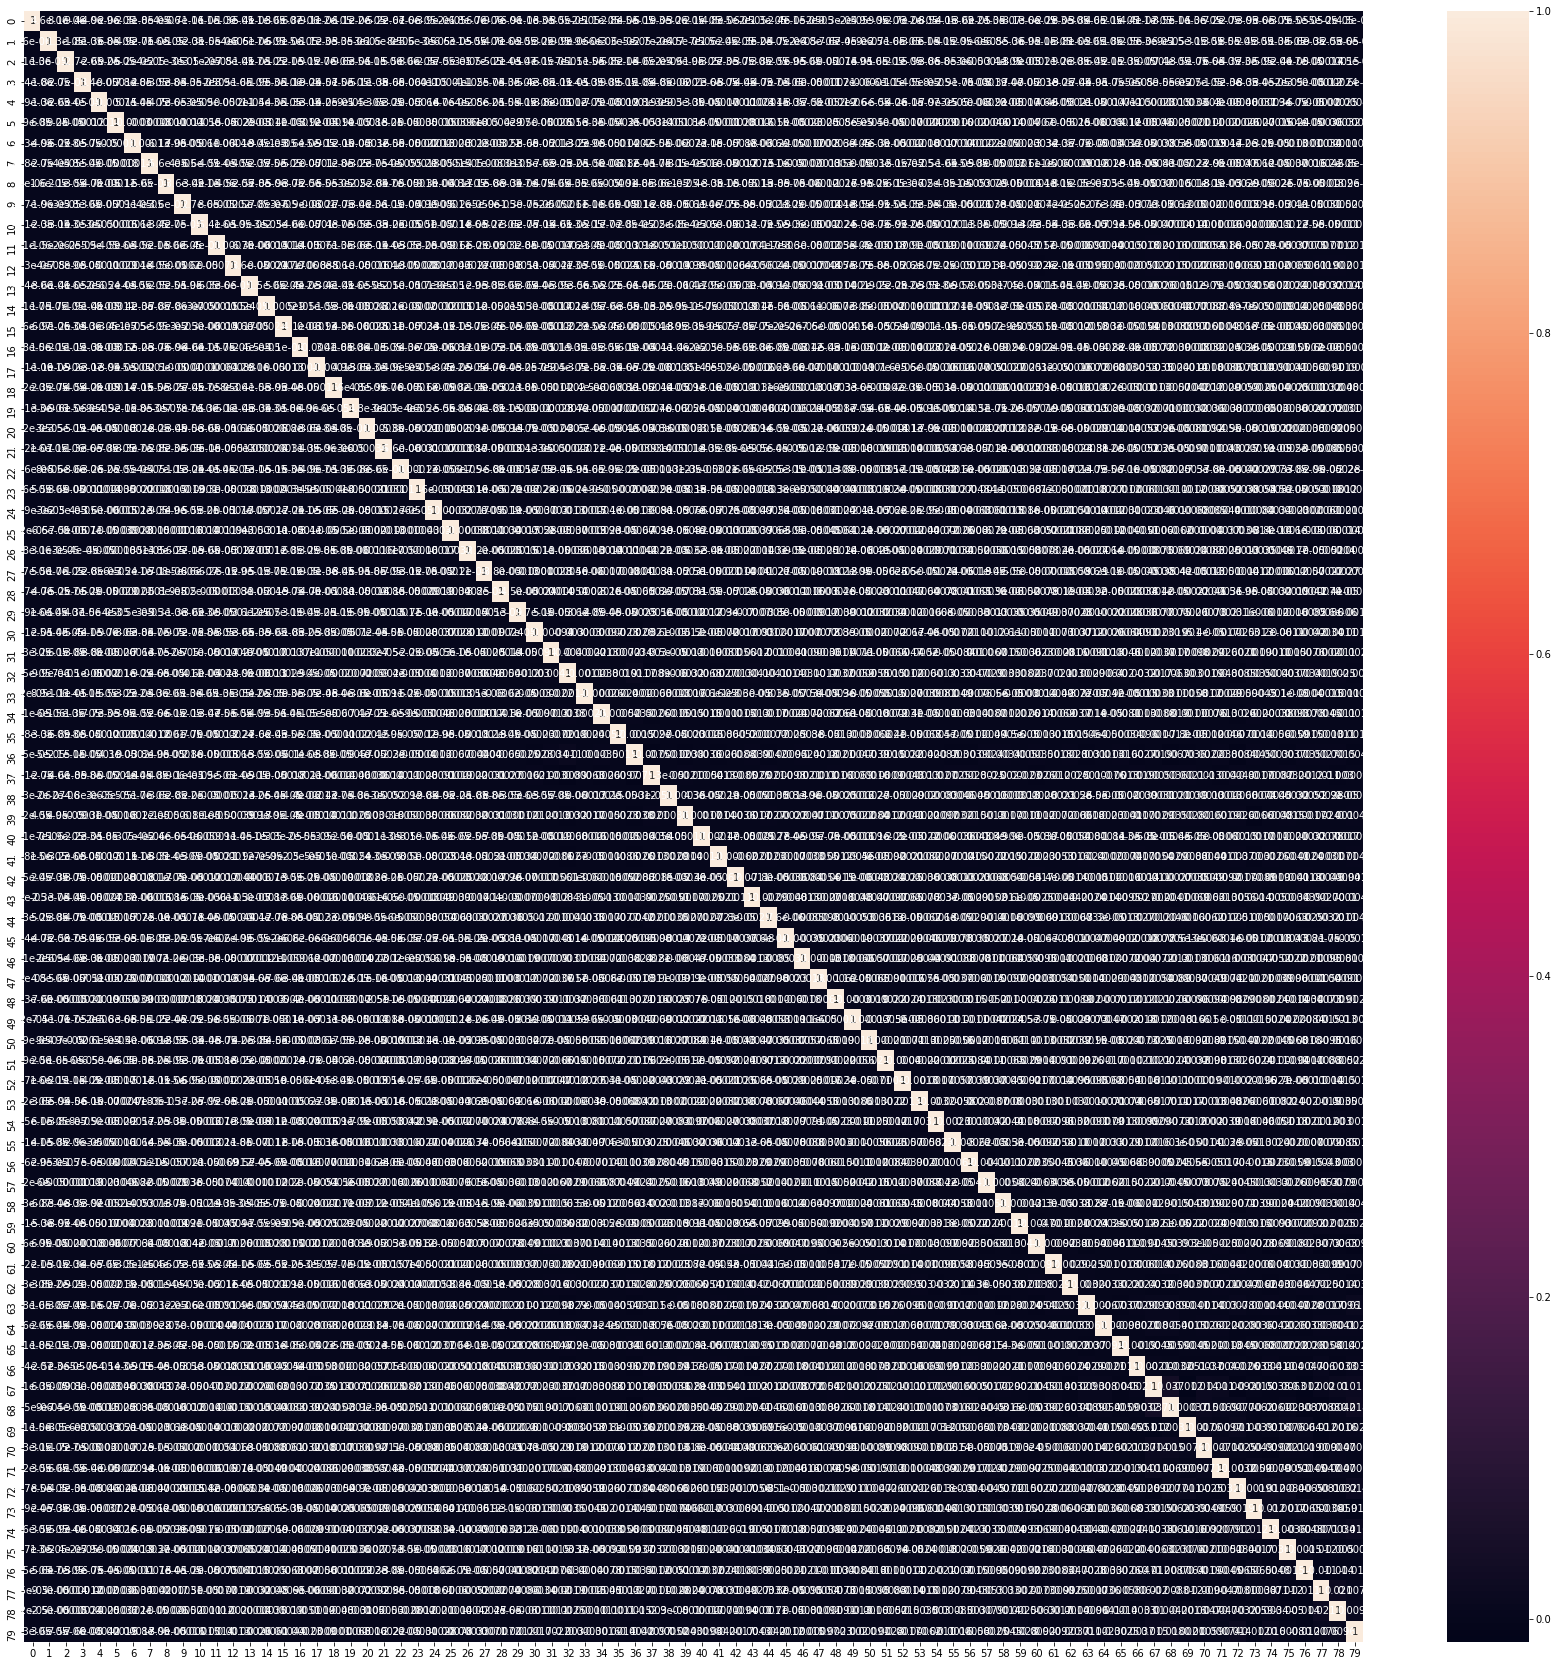

In [71]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (30,30))
sns.heatmap(corrmat,annot = True)

We can see there is almost no correlation between the PCs and hence - We effectively have removed multicollinearity from our situation, and our models will be much more stable

In [74]:
#Applying selected components to the test data - 80 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(8994, 80)

### Logistic Regression model with PCA

In [72]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

In [77]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.89'

In [91]:
#evaluating other metrics
y_pred_pca = model_pca.predict(df_test_pca)
from sklearn.metrics import classification_report
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_pca)))
print(classification_report(y_test, y_pred_pca ))

Accuracy: 0.9181676673337781
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      8179
           1       0.61      0.26      0.37       815

   micro avg       0.92      0.92      0.92      8994
   macro avg       0.77      0.62      0.66      8994
weighted avg       0.90      0.92      0.90      8994



From above, we can see that although we are getting an overall accuracy of almost 92%, the recall for churners is very low at 26%.
For this case study, our most importanct task is to predict the churners accurately and hence a recall for churners as low as 26% is not good. This is mostly because of class imbalance in the datset and we will need to handle it to improve the recall.

From PCA, we cannot really find out features that affect the churn and hence next we will use RFE for model building and also to identify important features

### Logistic Regression with RFE and handling class imbalance

#### Using SMOTE for treating class imbalance

In [86]:
# Balancing DataSet
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state  = 2)
X_train_smote,y_train_smote = smt.fit_sample(X_train,y_train)

In [87]:
#converting outcome of smote as array to dataframe 
X_train_smote = pd.DataFrame(X_train_smote)
y_train_smote = pd.DataFrame(y_train_smote)

In [89]:
print("X_train_smote Dataframe Shape {}".format(X_train_smote.shape))
print("y_train_smote Dataframe Shape {}".format( y_train_smote.shape))

imb = (y_train_smote != 0).sum()/(y_train_smote == 0).sum()
print("Imbalance in Train Data : ",imb)

X_train_smote Dataframe Shape (38422, 145)
y_train_smote Dataframe Shape (38422, 1)
Imbalance in Train Data :  0    1.0
dtype: float64


### RFE on balanced datset

In [92]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 20)             # running RFE with 20 variables as output
rfe = rfe.fit(X_train_smote,y_train_smote)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)           # Printing the ranking

[False False False False False  True False False False False False False
 False False False False  True False False False  True False False False
 False False False False False False False False  True False False  True
 False False False False False False False  True False False False False
 False False  True False False  True False False  True False  True False
 False False False False False  True False False False False False False
 False False False False False False False  True  True False False  True
 False False False False False False False False False False False False
 False False False False False  True False False  True False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False  True
 False False False  True False False False False False  True False False
 False]
[  6  31 105  42  15   1  41  35  16  44  62  63  78  14  18  39   1  60
  94 106   1  82  66 116 101 100  37 108  7

In [93]:
#selected features
X_train.columns[rfe.support_]

Index(['onnet_mou_8', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_8',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'isd_og_mou_7', 'og_others_8',
       'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7',
       'loc_ic_mou_8', 'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'monthly_2g_8',
       'monthly_3g_8', 'aon', 'diff_rch_days_8'],
      dtype='object')

In [94]:
col = X_train_smote.columns[rfe.support_]

## Logistic regression on RFE selected features

In [95]:

# runningthe model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(C=1e9)
logsk.fit(X_train_smote[col], y_train_smote)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [97]:
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
logreg1 = sm.GLM(y_train_smote,(sm.add_constant(X_train_smote[col])), family = sm.families.Binomial())
model = logreg1.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      0   No. Observations:                38422
Model:                            GLM   Df Residuals:                    38401
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15002.
Date:                Sat, 02 Nov 2019   Deviance:                       30004.
Time:                        14:05:52   Pearson chi2:                 1.86e+05
No. Iterations:                    10   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1133      0.035    -60.657      0.000      -2.182      -2.045
5              1.8924      0.148     12.782      0.000       1.602       2.183
16             0.3940      0.048      8.150      0.000       0.299       0.489
20             1.3416      0.118     11.405      0.000       1.111       1.572
32             1.4209      0.147      9.635      0.000       1.132       1.710
35             3.3014      0.184     17.985      0.000       2.942       3.661
43             0.3701      0.027     13.513      0.000       0.316       0.424
50            -2.2461      1.011     -2.222      0.026      -4.228      -0.264
53            -5.8257      0.298    -19.555      0.000      -6.410      -5.242
56             0.4716      0.091      5.186      0.000       0.293       0.650
58             0.6114      0.054     11.357      0.000       0.506       0.717
65            -1.7686      0.131    -13.454      0.000      -2.026      -1.511
79             0.4529      0.049      9.159      0.000       0.356       0.550
80            -1.1154      0.092    -12.172      0.000      -1.295      -0.936
83            -0.6953      0.038    -18.098      0.000      -0.771      -0.620
101           -0.5027      0.025    -20.071      0.000      -0.552      -0.454
104           -0.5160      0.030    -17.485      0.000      -0.574      -0.458
125           -0.5938      0.031    -19.245      0.000      -0.654      -0.533
131           -0.4517      0.032    -14.165      0.000      -0.514      -0.389
135           -0.3986      0.019    -20.906      0.000      -0.436      -0.361
141            0.4539      0.016     28.518      0.000       0.423       0.485
==============================================================================
"""

all p-values look good within the range so we are set for making predictions

In [98]:
#prediction
X_test_rfe = pd.DataFrame(data = X_test).iloc[:, rfe.support_]
y_pred = logsk.predict(X_test_rfe)

In [100]:
#evaluation
from sklearn.metrics import classification_report
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 0.8103179897709584
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      8179
           1       0.30      0.83      0.44       815

   micro avg       0.81      0.81      0.81      8994
   macro avg       0.64      0.82      0.66      8994
weighted avg       0.92      0.81      0.85      8994



From above we can see that using SMOTE, we have improved the recall for churners to 83% which is quite reasonable.
Also using RFE, we have found that the following features affect the churn the most:



'onnet_mou_8', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_8',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'isd_og_mou_7', 'og_others_8',
       'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7',
       'loc_ic_mou_8', 'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'monthly_2g_8',
       'monthly_3g_8', 'aon', 'diff_rch_days_8'],
      dtype='object'

## Random Forest with default hyperparameters

In [42]:
# Putting feature variable to TreeX
TreeX = high_value_cust_data.drop('Churn',axis=1)

# Putting response variable to TreeY
TreeY = high_value_cust_data['Churn']

# Splitting the data into train and test
TreeX_train, TreeX_test, TreeY_train, TreeY_test = train_test_split(TreeX, TreeY, test_size=0.30, random_state=101)


In [80]:
# Importing test_train_split from sklearn library
from sklearn.model_selection import train_test_split

# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [45]:
#running random forest with default parameters except class_weight to cater to data imbalance
rfc = RandomForestClassifier(class_weight='balanced')

In [46]:
# Fit
rfc.fit(TreeX_train,TreeY_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [47]:
# Making predictions
predictions = rfc.predict(TreeX_test)

In [51]:
# evaluation
print("Accuracy: {}".format(metrics.accuracy_score(TreeY_test,predictions)))
print(classification_report(TreeY_test,predictions))

Accuracy: 0.9385145652657327
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8209
           1       0.78      0.41      0.54       785

   micro avg       0.94      0.94      0.94      8994
   macro avg       0.87      0.70      0.75      8994
weighted avg       0.93      0.94      0.93      8994



From above, we can see although we have accuracy as almost 94%, but the recall score on churners is low at 41%.
We will now try to improve this by tuning the hyperparameters

### Random Forest with Hyperparameter tuning

#### Grid Search cross validation

In [52]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300,500], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [53]:
# Fit the grid search to the data
grid_search.fit(TreeX_train,TreeY_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 22.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [4, 8, 10], 'min_samples_leaf': range(100, 400, 200), 'min_samples_split': range(200, 500, 200), 'n_estimators': [100, 200, 300, 500], 'max_features': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [54]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.9038360733857518 using {'max_depth': 4, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 200}


In [55]:
# model with the best hyperparameters
rfc = RandomForestClassifier(bootstrap=True,
                             class_weight='balanced',
                             max_depth=4,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=200)

In [56]:
# Fit
rfc.fit(TreeX_train,TreeY_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features=10,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

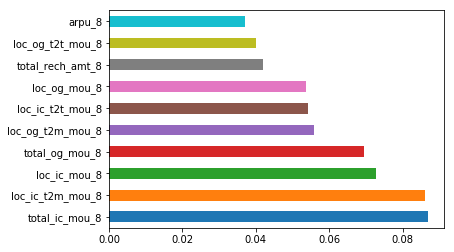

In [63]:
# Plot Important Features predicted by model.
feat_importances = pd.Series(rfc.feature_importances_, index=TreeX_train.columns)
feat_importances.nlargest(10).plot(kind='barh')


In [59]:
# Predict
predictions_tuned = rfc.predict(TreeX_test)

In [60]:
# evaluation
print("Accuracy: {}".format(metrics.accuracy_score(TreeY_test,predictions_tuned)))
print(classification_report(TreeY_test,predictions_tuned))

Accuracy: 0.9099399599733156
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      8209
           1       0.49      0.72      0.58       785

   micro avg       0.91      0.91      0.91      8994
   macro avg       0.73      0.82      0.77      8994
weighted avg       0.93      0.91      0.92      8994



From above we can observe that random forest with tuned hyperparameters improves the recall on churners considerably and recall is now 72%. 

Also from the plot above, we can see important features identified by random forest.


## Gradient Boosting Model with tuned hyperparameters

In [64]:
# Importing gradient boosting classifier from sklearn library
from sklearn.ensemble import GradientBoostingClassifier

In [65]:
# parameter grid
param_grid = {"learning_rate": [0.2, 0.6, 0.9],
              "subsample": [0.3, 0.6, 0.9]
             }

In [66]:
# GBM with the tree as base estimator
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

In [67]:
# run grid search
folds = 3
grid_search_GBC = GridSearchCV(GBC, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'accuracy', 
                               return_train_score=True,                         
                               verbose = 1)

grid_search_GBC.fit(TreeX_train,TreeY_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  7.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.2, 0.6, 0.9], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [68]:
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,12.413541,0.170971,0.058709,0.006188,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.935392,0.934239,0.942236,0.937289,0.003530,3,0.952105,0.950536,0.945322,0.949321,0.002899
1,18.961407,0.439294,0.073283,0.014501,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.938822,0.939957,0.943809,0.940863,0.002134,1,0.959683,0.954610,0.956686,0.956993,0.002082
2,18.958072,0.580492,0.065051,0.014862,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.939394,0.937527,0.943380,0.940100,0.002441,2,0.960040,0.959471,0.957258,0.958923,0.001200
3,11.420594,0.225121,0.060189,0.007530,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.928959,0.926805,0.935373,0.930379,0.003639,6,0.942598,0.943531,0.945179,0.943769,0.001067
4,16.778954,0.191931,0.046986,0.004094,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.932676,0.934811,0.940377,0.935954,0.003247,5,0.957252,0.953610,0.946180,0.952347,0.004608


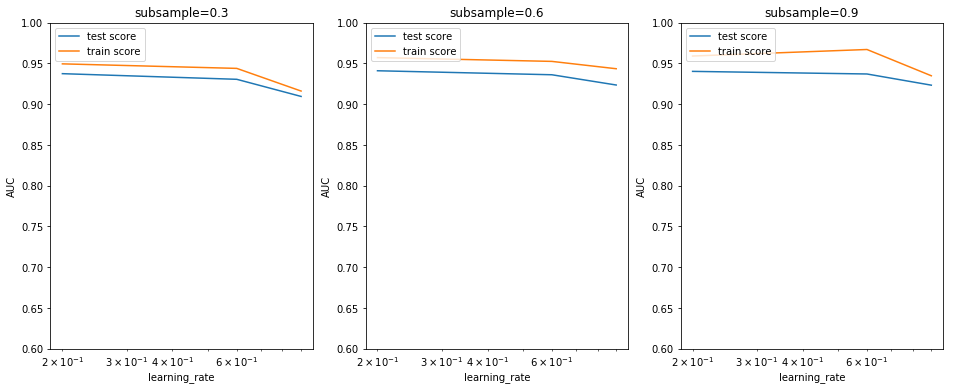

In [69]:
# # plotting
plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [71]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search_GBC.best_score_,'using',grid_search_GBC.best_params_)

We can get accuracy of 0.940862520848225 using {'learning_rate': 0.2, 'subsample': 0.6}


In [72]:
# model with the best hyperparameters
gbc = GradientBoostingClassifier(max_depth=2, 
                                 n_estimators=200,
                                learning_rate = 0.2,
                                subsample = 0.6)

In [74]:
# Fit
gbc.fit(TreeX_train,TreeY_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.6, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

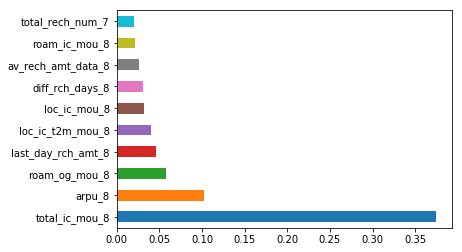

In [77]:
# Plot Important Features predicted by model.
feat_importances = pd.Series(gbc.feature_importances_, index=TreeX_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [75]:
# Predict
predictions_gbc = gbc.predict(TreeX_test)

In [76]:
# evaluation
print("Accuracy: {}".format(metrics.accuracy_score(TreeY_test,predictions_gbc)))
print(classification_report(TreeY_test,predictions_gbc))

Accuracy: 0.9407382699577496
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8209
           1       0.73      0.52      0.60       785

   micro avg       0.94      0.94      0.94      8994
   macro avg       0.84      0.75      0.79      8994
weighted avg       0.93      0.94      0.94      8994



From above we can see that although accuracy is very high at 94%, the recall score of churners that we are getting is quite low at 52%.
Hence we are better off in using Logistic Regression and Random forest - where both accuracy and recall were reasonably high - as better models for this case study